In [1]:
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [2]:
resnet_pretrained = models.resnet50(pretrained=True)
nn.Conv2d = Conv2d_Attn
resnet_attn = models.resnet50()
resnet_attn.load_state_dict(resnet_pretrained.state_dict(), strict=False)

In [3]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
param_keys = list(resnet_attn.state_dict().keys())
formatted_keys = []
for k in param_keys:
    found = re.findall(r'\.[\d]{1,2}\.', k)
    if len(found):
        for f in found:
            k = k.replace(f, '[{}].'.format(f.strip('.')))
    formatted_keys.append(k)

In [4]:
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(lst=[]):
    for k in formatted_keys:
        obj = eval('resnet_attn.'+k)
        for kw in lst:
            if not kw in k:
                obj.requires_grad = False
            else:
                obj.requires_grad = True

In [5]:
resnet_attn.fc = nn.Linear(resnet_attn.fc.in_features, 144)

Start training

In [6]:
batch_size = 32

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [8]:
total_imgs = len(trainset.imgs)

In [9]:
resnet_attn = resnet_attn.cuda()

In [10]:
total_attn_params = 0
for k in formatted_keys:
    obj = eval('resnet_attn.'+k)
    if 'attn_weights' in k:
        total_attn_params += np.prod(obj.shape)
print("Total number of attention parameters", total_attn_params)

Total number of attention parameters 26560


We want the attention parameters to diverge from 1, therefore we penalize element-wise square loss as $\lambda (1 \times \text{# params} - (x - 1)^2)$

But this is too big a number,
let's try: 
$- (x - 1)^2$ for now

In [11]:
_lambda = 1e-2 #set default

In [12]:
def get_params_objs(name, net='resnet_attn'):
    res = []
    for k in formatted_keys:
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [13]:
def compute_attn_loss(n_params=26560):
    attns = get_params_objs('attn_weights')
    penality = sum([torch.pow(t - 1,2).mean() for t in attns])
    return _lambda*(- penality)

In [14]:
print_every = 5

In [15]:
def train_one_epoch(add_attn=True):
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_attn.parameters()))
    
    running_loss = 0.0
    running_attn_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

        optimizer.zero_grad()
        outputs = resnet_attn(inputs)
        loss = cls_criterion(outputs, labels)
        attn_loss = compute_attn_loss()
        if add_attn:
            loss += attn_loss

        loss.backward()
        optimizer.step()


        running_loss += loss.data[0]
        running_attn_loss += attn_loss.data[0]

        if i % print_every == 0:
            print('[%5d] iter, [%2f] epoch, avg loss: %.3f, attn_loss: %.5f ' %
                  (i + 1, i*batch_size/total_imgs, running_loss/print_every, running_attn_loss/print_every))
            running_loss = 0.0
            running_attn_loss = 0.0

In [19]:
from tqdm import tqdm
def score(net=resnet_attn, batch_size=batch_size):
    trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    train_correct = 0
    val_correct = 0
    
    for inp, label in tqdm(iter(trainloader)):
        _, idx = net(Variable(inp).cuda()).topk(3)
        train_correct += int(sum(idx.cpu().data == label))
    
    for inp, label in tqdm(iter(valloader)):
        _, idx = net(Variable(inp).cuda()).topk(3)
        val_correct += int(sum(idx.cpu().data == label))
    
    return {
        'train_accu': train_correct/len(trainset),
        'val_accu': val_correct/len(valset)
    }

Train a fresh fc layer. 
`turn_off_grad_except([])` turns off grads for all weights but the fc layer

In [16]:
turn_off_grad_except(['fc'])
resnet_attn.eval() # Turn on batchnorm
train_one_epoch(add_attn=False)

[    1] iter, [0.000000] epoch, avg loss: 1.016, attn_loss: 0.00000 
[    6] iter, [0.019605] epoch, avg loss: 4.964, attn_loss: 0.00000 
[   11] iter, [0.039211] epoch, avg loss: 4.760, attn_loss: 0.00000 
[   16] iter, [0.058816] epoch, avg loss: 4.470, attn_loss: 0.00000 
[   21] iter, [0.078422] epoch, avg loss: 4.109, attn_loss: 0.00000 
[   26] iter, [0.098027] epoch, avg loss: 4.484, attn_loss: 0.00000 
[   31] iter, [0.117633] epoch, avg loss: 4.379, attn_loss: 0.00000 
[   36] iter, [0.137238] epoch, avg loss: 3.903, attn_loss: 0.00000 
[   41] iter, [0.156844] epoch, avg loss: 4.099, attn_loss: 0.00000 
[   46] iter, [0.176449] epoch, avg loss: 3.918, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, avg loss: 4.117, attn_loss: 0.00000 
[   56] iter, [0.215660] epoch, avg loss: 3.676, attn_loss: 0.00000 
[   61] iter, [0.235265] epoch, avg loss: 3.515, attn_loss: 0.00000 
[   66] iter, [0.254871] epoch, avg loss: 3.373, attn_loss: 0.00000 
[   71] iter, [0.274476] epoch, av

In [17]:
valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [36]:
correct_count = 0
for inp, label in iter(valloader):
    _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
    lab = Variable(label).cuda()
    lab_expand = lab.unsqueeze(1).expand_as(idx)
    correct_count += int((idx == lab_expand).sum())

In [37]:
correct_count/len(valset)

0.5245153933865451

In [38]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
_lambda = 1
train_one_epoch(add_attn=True)

[    1] iter, [0.000000] epoch, avg loss: 0.486, attn_loss: 0.00000 
[    6] iter, [0.019605] epoch, avg loss: 2.573, attn_loss: -0.00020 
[   11] iter, [0.039211] epoch, avg loss: 2.478, attn_loss: -0.00065 
[   16] iter, [0.058816] epoch, avg loss: 2.402, attn_loss: -0.00120 
[   21] iter, [0.078422] epoch, avg loss: 2.339, attn_loss: -0.00191 
[   26] iter, [0.098027] epoch, avg loss: 2.246, attn_loss: -0.00275 
[   31] iter, [0.117633] epoch, avg loss: 2.399, attn_loss: -0.00365 
[   36] iter, [0.137238] epoch, avg loss: 2.384, attn_loss: -0.00455 
[   41] iter, [0.156844] epoch, avg loss: 2.384, attn_loss: -0.00555 
[   46] iter, [0.176449] epoch, avg loss: 2.359, attn_loss: -0.00664 
[   51] iter, [0.196054] epoch, avg loss: 2.202, attn_loss: -0.00788 
[   56] iter, [0.215660] epoch, avg loss: 2.175, attn_loss: -0.00929 
[   61] iter, [0.235265] epoch, avg loss: 2.203, attn_loss: -0.01086 
[   66] iter, [0.254871] epoch, avg loss: 2.054, attn_loss: -0.01259 
[   71] iter, [0.2744

In [39]:
from tqdm import tqdm

In [40]:
correct_count = 0
for inp, label in tqdm(iter(valloader)):
    _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
    lab = Variable(label).cuda()
    lab_expand = lab.unsqueeze(1).expand_as(idx)
    correct_count += int((idx == lab_expand).sum())
print(correct_count/len(valset))

100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

0.5872291904218928


In [42]:
def score_top3():
    correct_count = 0
    for inp, label in tqdm(iter(valloader)):
        _, idx = resnet_attn(Variable(inp).cuda()).topk(3)
        lab = Variable(label).cuda()
        lab_expand = lab.unsqueeze(1).expand_as(idx)
        correct_count += int((idx == lab_expand).sum())
    print(correct_count/len(valset))

In [43]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
_lambda = 1
train_one_epoch(add_attn=True)
score_top3()

[    1] iter, [0.000000] epoch, avg loss: 0.418, attn_loss: -0.05450 
[    6] iter, [0.019605] epoch, avg loss: 1.597, attn_loss: -0.27796 
[   11] iter, [0.039211] epoch, avg loss: 1.961, attn_loss: -0.28708 
[   16] iter, [0.058816] epoch, avg loss: 1.766, attn_loss: -0.29619 
[   21] iter, [0.078422] epoch, avg loss: 2.021, attn_loss: -0.30543 
[   26] iter, [0.098027] epoch, avg loss: 1.909, attn_loss: -0.31477 
[   31] iter, [0.117633] epoch, avg loss: 1.771, attn_loss: -0.32432 
[   36] iter, [0.137238] epoch, avg loss: 1.895, attn_loss: -0.33424 
[   41] iter, [0.156844] epoch, avg loss: 1.767, attn_loss: -0.34440 
[   46] iter, [0.176449] epoch, avg loss: 1.812, attn_loss: -0.35471 
[   51] iter, [0.196054] epoch, avg loss: 1.832, attn_loss: -0.36517 
[   56] iter, [0.215660] epoch, avg loss: 1.652, attn_loss: -0.37587 
[   61] iter, [0.235265] epoch, avg loss: 1.763, attn_loss: -0.38702 
[   66] iter, [0.254871] epoch, avg loss: 1.826, attn_loss: -0.39857 
[   71] iter, [0.274

100%|██████████| 55/55 [00:14<00:00,  3.92it/s]

0.6088939566704675


In [45]:
attns = get_params_objs('attn_weights')

In [48]:
attns = torch.cat([attn.squeeze() for attn in attns])

In [50]:
attns_arr = attns.data.cpu().numpy()

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

(array([  260.,    84.,   164.,   971., 12044., 11546.,   989.,   167.,
           82.,   253.]),
 array([0.31773689, 0.45415982, 0.59058275, 0.72700568, 0.86342861,
        0.99985154, 1.13627447, 1.2726974 , 1.40912033, 1.54554326,
        1.68196619]),
 <a list of 10 Patch objects>)

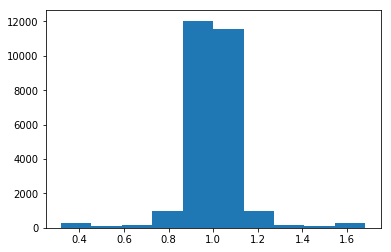

In [52]:
plt.hist(attns_arr)

In [54]:
turn_off_grad_except(['attn_weights'])
resnet_attn.eval() # Turn on batchnorm
_lambda = 1
train_one_epoch(add_attn=True)
score_top3()

[    1] iter, [0.000000] epoch, avg loss: 0.201, attn_loss: -0.22491 
[    6] iter, [0.019605] epoch, avg loss: 0.914, attn_loss: -1.13828 
[   11] iter, [0.039211] epoch, avg loss: 0.851, attn_loss: -1.16156 
[   16] iter, [0.058816] epoch, avg loss: 1.016, attn_loss: -1.18541 
[   21] iter, [0.078422] epoch, avg loss: 0.810, attn_loss: -1.20941 
[   26] iter, [0.098027] epoch, avg loss: 0.570, attn_loss: -1.23363 
[   31] iter, [0.117633] epoch, avg loss: 0.805, attn_loss: -1.25819 
[   36] iter, [0.137238] epoch, avg loss: 0.780, attn_loss: -1.28330 
[   41] iter, [0.156844] epoch, avg loss: 0.720, attn_loss: -1.30885 
[   46] iter, [0.176449] epoch, avg loss: 0.417, attn_loss: -1.33479 
[   51] iter, [0.196054] epoch, avg loss: 0.404, attn_loss: -1.36131 
[   56] iter, [0.215660] epoch, avg loss: 0.739, attn_loss: -1.38832 
[   61] iter, [0.235265] epoch, avg loss: 0.849, attn_loss: -1.41593 
[   66] iter, [0.254871] epoch, avg loss: 0.417, attn_loss: -1.44391 
[   71] iter, [0.274

100%|██████████| 55/55 [00:14<00:00,  3.93it/s]

0.61345496009122
